In [1]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

/bin/bash: line 1: nvcc: command not found
torch:  2.0 ; cuda:  cu117
detectron2: 0.6


In [2]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [6]:


%matplotlib inline
#The line above is necesary to show Matplotlib's plots inside a Jupyter Notebook

import cv2
from matplotlib import pyplot as plt


def show_image_with_matplotlib(color_img, title="Image", pos=1):
    """Shows an image using matplotlib capabilities"""

    # Convert BGR image to RGB
    img_RGB = color_img[:, :, ::-1]

    ax = plt.subplot(1, 1, pos)
    plt.imshow(img_RGB)
    plt.title(title)
    plt.axis('off')

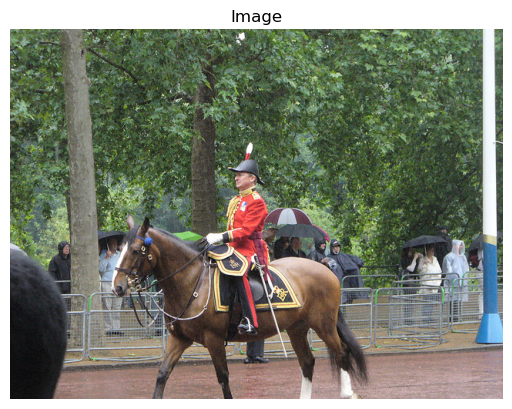

In [7]:
!wget http://images.cocodataset.org/val2017/000000439715.jpg -q -O input.jpg
im = cv2.imread("./input.jpg")
show_image_with_matplotlib(im)

In [8]:
from detectron2.data.datasets import register_coco_instances
train_annotation_path = "/home/jonasklotz/DSSGx/dssgx_land_sealing_dataset_analysis/data/labelled_data/result.json"
train_image_path = "/home/jonasklotz/DSSGx/dssgx_land_sealing_dataset_analysis/data/labelled_data/images"

val_annotation_path = train_annotation_path
val_image_path = train_image_path

register_coco_instances("bplan_layout_train", {}, train_annotation_path, train_image_path)
register_coco_instances("bplan_layout_val", {}, val_annotation_path, val_image_path)


In [ ]:
def parse_img_path(img_path):
    return img_path.split("/")[-1]

WARNING [08/19 07:58:47 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/19 07:58:47 d2.data.datasets.coco]: Loaded 5 images in COCO format from /home/jonasklotz/DSSGx/dssgx_land_sealing_dataset_analysis/data/labelled_data/result.json


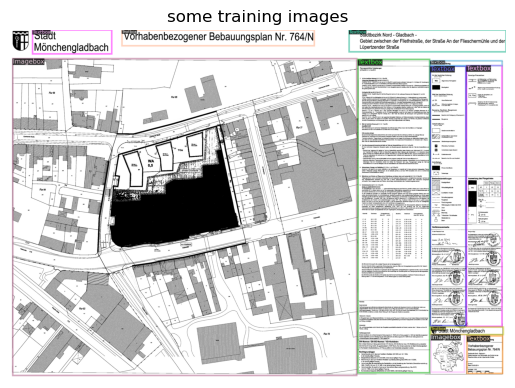

In [13]:
# plot some training images
import random
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

dataset_dicts = DatasetCatalog.get("bplan_layout_train")
bplan_metadata = MetadataCatalog.get("bplan_layout_train")

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=bplan_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    show_image_with_matplotlib(vis.get_image()[:, :, ::-1], "some training images", pos=1)

In [14]:
from detectron2.engine import DefaultTrainer
model_path = "/home/jonasklotz/DSSGx/dssgx_land_sealing_dataset_analysis/models/layout_segmentation/model_final.pth"
config_path = "/home/jonasklotz/DSSGx/dssgx_land_sealing_dataset_analysis/models/layout_segmentation/config.yaml"
cfg = get_cfg()
# setup model and weights
cfg.merge_from_file(config_path)
cfg.MODEL.WEIGHTS = model_path
# setup training data
cfg.DATASETS.TRAIN = ("bplan_layout_train",)
cfg.DATASETS.TEST = ()

cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2


In [15]:

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx